In [15]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import text2term

import ast
import csv

from collections import Counter, deque

## Jaccard Similarity

In [16]:
gpt_output = pd.read_csv('outputs/raw_model_outputs.csv')

In [17]:
# Remove any EDAM not in the list
with open('EDAM/edam_topics.txt') as edam_file:
    full_edam_topics = edam_file.readlines()

full_edam_topics = [topic.strip() for topic in full_edam_topics]

In [18]:
gpt_output['Ground Truth'] = gpt_output['Ground Truth'].apply(lambda str: set(ast.literal_eval(str)))
# gpt_output['Predictions'] = gpt_output['Predictions'].apply(lambda str: set(str.split(', ')))
gpt_output['Predictions'] = gpt_output['Predictions'].apply(lambda str: set(ast.literal_eval(str)))

In [19]:
gpt_output['Hallucinations'] = gpt_output['Predictions'].apply(lambda preds: set([pred.replace('.', '').replace('\"', '') for pred in preds if pred.replace('.', '').replace('\"', '') not in full_edam_topics]))

In [20]:
# gpt_output['New Ground Truth'] = gpt_output['New Ground Truth'].apply(lambda x: set([term.replace('Zoology', 'Animal Study').replace('Drug metabolism', 'Endocrinology and Metabolism') for term in x]))

# Remove Hallucinated Topics and misplaced punctuation
gpt_output['Predictions'] = gpt_output['Predictions'].apply(lambda preds: set([pred.replace('.', '').replace('\"', '') for pred in preds if pred.replace('.', '').replace('\"', '') in full_edam_topics]))
gpt_output['Predictions'] = gpt_output.apply(lambda row: set([topic for topic in row['Predictions'] if topic not in row['Hallucinations']]), axis=1)

In [21]:
def jaccard_similarity(row):
    set1, set2 = row['Ground Truth'], row['Predictions']
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
     
    return intersection / union

In [22]:
gpt_output['Jaccard Similarity'] = gpt_output.apply(jaccard_similarity, axis=1)

Model
ft:gpt-3.5-turbo-0613:personal::8SAHvdnS    Axes(0.125,0.11;0.775x0.77)
ft:gpt-3.5-turbo-0613:personal::8SD8i1on    Axes(0.125,0.11;0.775x0.77)
ft:gpt-3.5-turbo-1106:personal::8SDAGTmv    Axes(0.125,0.11;0.775x0.77)
gpt-3.5-turbo                               Axes(0.125,0.11;0.775x0.77)
gpt-4                                       Axes(0.125,0.11;0.775x0.77)
mixtral-8x7b-model                          Axes(0.125,0.11;0.775x0.77)
Name: Jaccard Similarity, dtype: object

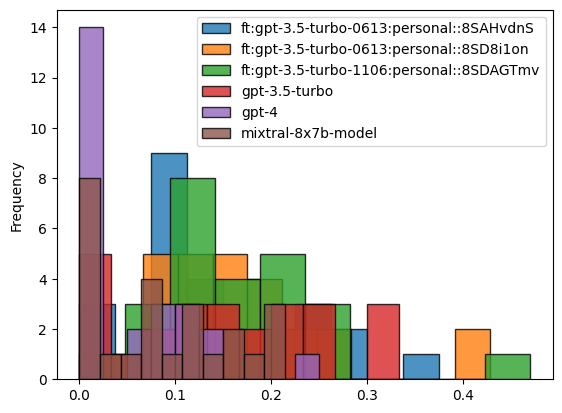

In [23]:
fig, ax = plt.subplots()

gpt_output.groupby('Model')['Jaccard Similarity'].plot(kind='hist', alpha=0.8, legend=True, edgecolor='black', ax=ax)

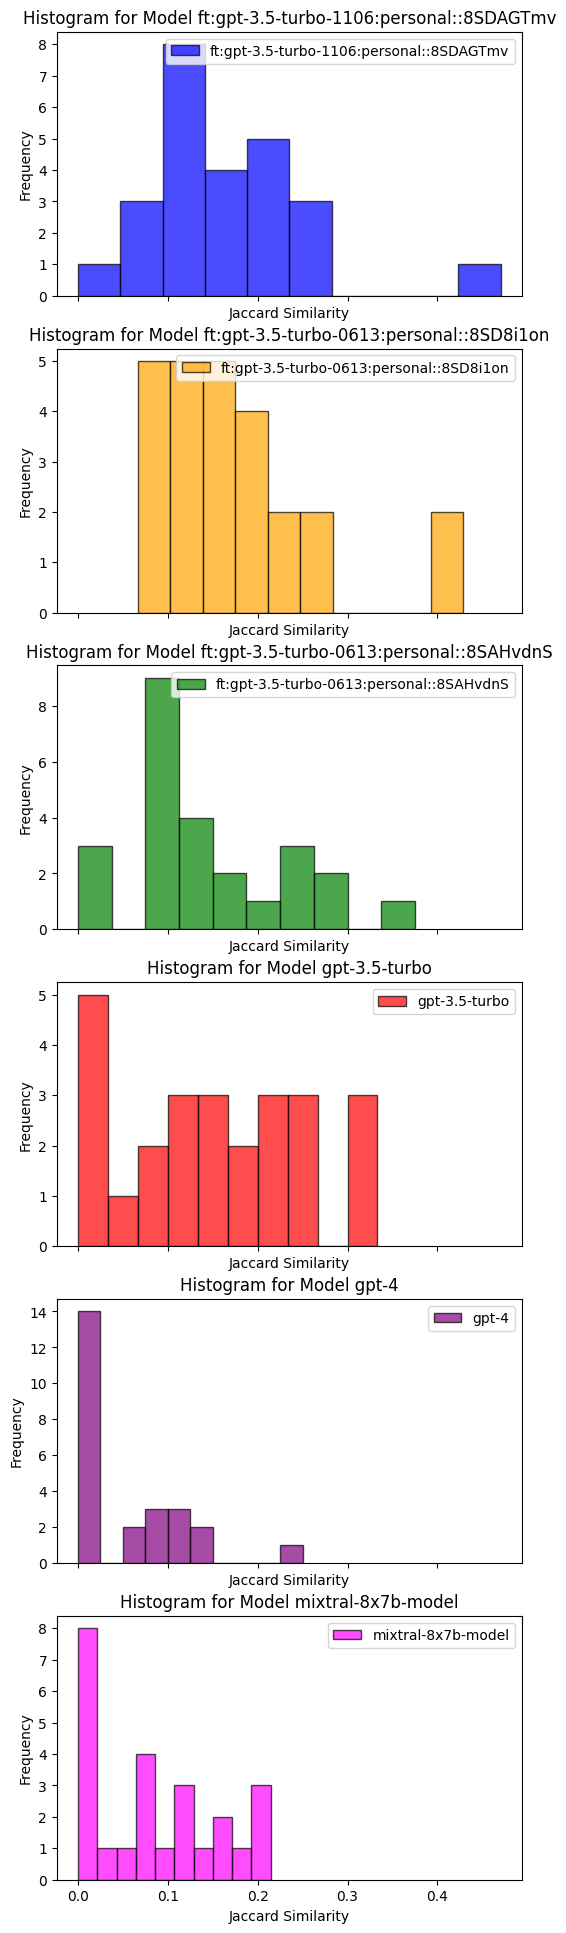

In [24]:
unique_labels = gpt_output['Model'].unique()

fig, axs = plt.subplots(len(unique_labels), 1, figsize=(6, 4 * len(unique_labels)), sharex=True)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'magenta']
# Plot histograms for each label
for i, label in enumerate(unique_labels):
    subset = gpt_output[gpt_output['Model'] == label]
    axs[i].hist(subset['Jaccard Similarity'], bins=10, alpha=0.7, edgecolor='black', label=label, color=colors[i])
    axs[i].set_title(f'Histogram for Model {label}')
    axs[i].set_xlabel('Jaccard Similarity')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

## Gather more model metrics

Precision, Recall, Jaccard Similarity

In [25]:
def calculate_precision_recall_per_row(ground_truth, predictions):
    precision_per_row = []
    recall_per_row = []

    for truth_labels, predicted_labels in zip(ground_truth, predictions):

        true_positives = len(truth_labels.intersection(predicted_labels))
        false_positives = len(predicted_labels - truth_labels)
        false_negatives = len(truth_labels - predicted_labels)

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0

        precision_per_row.append(precision)
        recall_per_row.append(recall)

    return precision_per_row, recall_per_row


precision, recall = calculate_precision_recall_per_row(gpt_output['Ground Truth'], gpt_output['Predictions'])

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: [0.125, 0.16666666666666666, 0.13333333333333333, 0.3333333333333333, 0.2, 0.25, 0.3, 0.2222222222222222, 0.2222222222222222, 0.125, 0.3333333333333333, 0.08333333333333333, 0.125, 0.2, 0.2857142857142857, 0.16666666666666666, 0.5, 0.0, 0.4, 0.4, 0.3333333333333333, 0.25, 0.2857142857142857, 0.2857142857142857, 0.25, 0.14285714285714285, 0.25, 0.1875, 0.5, 0.3, 0.25, 0.2, 0.2222222222222222, 0.2222222222222222, 0.25, 0.375, 0.3076923076923077, 0.125, 0.2, 0.2857142857142857, 0.2, 0.3125, 0.3333333333333333, 0.6, 0.2, 0.2222222222222222, 0.25, 0.14285714285714285, 0.2857142857142857, 0.25, 0.125, 0.4166666666666667, 0.25, 0.3333333333333333, 0.3, 0.25, 0.0, 0.3333333333333333, 0.1111111111111111, 0.125, 0.2222222222222222, 0.23076923076923078, 0.25, 0.2, 0.14285714285714285, 0.0, 0.125, 0.0, 0.4, 0.6, 0.3333333333333333, 0.3333333333333333, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.0, 0.25, 0.13333333333333333, 0.2, 0.4, 0.0, 0.14285714285714285, 0.33333

In [26]:
gpt_output['Precision'] = precision
gpt_output['Recall'] = recall

## Added terms & Subtracted terms

Added terms and subtracted terms for each model against gpt3.5 and ground truth

In [27]:
# Against ground truth
def find_added_missing_labels(ground_truth, predictions):
    added_labels_per_row = []
    missing_labels_per_row = []

    for truth_labels, predicted_labels in zip(ground_truth, predictions):

        added_labels = predicted_labels - truth_labels
        missing_labels = truth_labels - predicted_labels

        added_labels_per_row.append(added_labels)
        missing_labels_per_row.append(missing_labels)

    return added_labels_per_row, missing_labels_per_row

added_labels_per_row, missing_labels_per_row = find_added_missing_labels(gpt_output['Ground Truth'], gpt_output['Predictions'])

In [28]:
gpt_output['Added Labels (Predictions against Ground Truth)'] = added_labels_per_row
gpt_output['Missing Labels (Predictions against Ground Truth)'] = missing_labels_per_row

In [29]:
# Set the reference model name you want to compare others against
reference_model_name = 'gpt-3.5-turbo'

added_labels, missing_labels = [], []
gpt3_preds = gpt_output[gpt_output['Model'] == reference_model_name]['Predictions']

for name, group in gpt_output.groupby('Model'):
    if name == reference_model_name:
        added_labels.extend(['N/A'] * 25)
        missing_labels.extend(['N/A'] * 25)
        continue
    
    added_labels_per_row, missing_labels_per_row = find_added_missing_labels(gpt3_preds, group['Predictions'])
    
    added_labels.extend(added_labels_per_row)
    missing_labels.extend(missing_labels_per_row)


In [30]:
gpt_output['Added Labels (Predictions against GPT-3.5)'] = added_labels
gpt_output['Missing Labels (Predictions against GPT-3.5)'] = missing_labels

In [31]:
# Remove any EDAM not in the list
with open('EDAM/edam_topics.txt', 'r') as edam_file:
    full_edam_topics = edam_file.readlines()

full_edam_topics = [topic.strip().replace('\"', '') for topic in full_edam_topics]

In [32]:
# Gather average values 

def get_average_metrics(dataset, average_metrics: dict, column_name):
    for name, group in dataset.groupby('Model'):
        average_metrics[name] = group[column_name].mean()

In [33]:
average_jaccard = dict()
average_precision = dict()
average_recall = dict()

get_average_metrics(gpt_output, average_jaccard, 'Jaccard Similarity')
get_average_metrics(gpt_output, average_precision, 'Precision')
get_average_metrics(gpt_output, average_recall, 'Recall')

In [34]:
print(average_jaccard, '\n')
print(average_precision, '\n')
print(average_recall, '\n')

{'ft:gpt-3.5-turbo-0613:personal::8SAHvdnS': 0.14539003846245735, 'ft:gpt-3.5-turbo-0613:personal::8SD8i1on': 0.17692454913507544, 'ft:gpt-3.5-turbo-1106:personal::8SDAGTmv': 0.15975781150394153, 'gpt-3.5-turbo': 0.14825713983299124, 'gpt-4': 0.047351791998850826, 'mixtral-8x7b-model': 0.08302678432678434} 

{'ft:gpt-3.5-turbo-0613:personal::8SAHvdnS': 0.22613553113553114, 'ft:gpt-3.5-turbo-0613:personal::8SD8i1on': 0.2645934065934066, 'ft:gpt-3.5-turbo-1106:personal::8SDAGTmv': 0.23906349206349206, 'gpt-3.5-turbo': 0.2607936507936508, 'gpt-4': 0.09438095238095238, 'mixtral-8x7b-model': 0.13594042799305955} 

{'ft:gpt-3.5-turbo-0613:personal::8SAHvdnS': 0.2918210678210678, 'ft:gpt-3.5-turbo-0613:personal::8SD8i1on': 0.3542453102453102, 'ft:gpt-3.5-turbo-1106:personal::8SDAGTmv': 0.32689466089466085, 'gpt-3.5-turbo': 0.243008658008658, 'gpt-4': 0.08246176046176046, 'mixtral-8x7b-model': 0.16765512265512264} 



In [35]:
gpt_output.to_csv('outputs/filtered_outputs_w_metrics.csv', index=False)

## New Scoring Technique

1. Calculate J-similarity, precision, recall and then remove the terms in common

2. Check if a prediction term is within the same tree as a ground truth term

3. If two terms are within the same tree:

- Treat the two terms as a match
- Determine which term is closer to the root ([http://edamontology.org/topic\_0003](http://edamontology.org/topic_0003))
  - Calculate a weight to apply depending on how close the closest term is to the root (Weight 1)
    - If closest term is one step away from root it should have a lower score than a closest term that is 2 steps away. This is to lower the weight of excessively generic terms (use: 1-(1/(# of steps to closest term))
  - Calculate a weight to apply depending on the number of steps between the two 'matching' terms (Weight 2)
    - If the closest term to root is the ground truth term, use: (1/(# of steps between the terms))
    - If the closest term to root is the prediction term, use: -(1/(# of steps between the terms)): It is negative only to ensure we will later be able to inspect the directionality
- The overall weight should be a combination of the two, for example:
- Overall weight = Weight 1 + ABS(Weight 2)
- Weighted similarity: Add the overall weight for all matches, then add the j-sim (since we previously removed exact matches)

**Adjusting for prediction number biases:**

- The weighted similarity will be advantageous to ChatGPT 4 due to its tendency to dump every relevant term
- To account for that, we can penalize it for making excessive guesses by multiplying the weighted similarity against the ratio of (# of gold standard terms)/(# of predicted terms).

**Evaluating whether the prediction has a tendency to be more specific or less specific than the gold standard**

- Broadness evaluation: (# of positive Weight 2 values)/(# of negative Weight 2 values)
- If broadness evaluation is \>1, LLM model predictions are more specific than Ground truth/gold standard terms
  - If broadness evaluation is \<1, LLM model predictions are less specific than ground truth/gold standard terms

In [36]:
import pandas as pd

edam_data = pd.read_csv("EDAM/EDAM.csv")
edam_data = edam_data[edam_data['Class ID'].str.startswith("http://edamontology.org/topic_")].sort_values(by='Preferred Label')

In [37]:
edam_data[~edam_data['Parents'].str.contains("http://edamontology.org/topic_")].head()[['Class ID', 'Preferred Label', 'Parents']]

,Class ID,Preferred Label,Parents
2996,http://edamontology.org/topic_3521,2D PAGE experiment,http://www.w3.org/2002/07/owl#DeprecatedClass
3002,http://edamontology.org/topic_0174,Ab initio structure prediction,http://www.w3.org/2002/07/owl#DeprecatedClass
3329,http://edamontology.org/topic_0083,Alignment,http://www.w3.org/2002/07/owl#DeprecatedClass
1690,http://edamontology.org/topic_0786,Arabidopsis,http://www.w3.org/2002/07/owl#DeprecatedClass
2435,http://edamontology.org/topic_3075,Biological system modelling,http://www.w3.org/2002/07/owl#DeprecatedClass


In [38]:
edam_data = edam_data[edam_data['Parents'].str.contains("http://edamontology.org/topic_")]

In [39]:
edam_data['Parents #'] = edam_data['Parents'].str.extractall(r'topic_(\d+)').groupby(level=0).agg(lambda parents: parents.tolist())
edam_data['Topic #'] = edam_data['Class ID'].apply(lambda url: url.split('topic_')[1])

In [40]:
plabel_topic_dict = dict(zip(edam_data['Preferred Label'], edam_data['Topic #']))

In [41]:
from collections import defaultdict

topic_dict = defaultdict(list)

for index, row in edam_data.iterrows():
    topic = row['Topic #']
    parents = row['Parents #']
    
    topic_dict[topic].extend(parents)

In [42]:
def shortest_distance(topic_dict, topic, verbose=False):
    
    queue = [(topic, 0, [topic])]
    visited = set()
    
    while queue:
        current_topic, distance, path = queue.pop(0)
        
        if current_topic == '0003':
            if verbose:
                print('Path to root: ', path)
            return distance
        
        visited.add(current_topic)
        
        if current_topic in topic_dict:
            parents = topic_dict[current_topic]
            
            for parent in parents:
                if parent not in visited:
                    queue.append((parent, distance + 1, path + [parent]))
    
    return -1  # If the root topic is not found

dist = shortest_distance(topic_dict, '4030')

print(dist)


2


In [43]:
parent_topic = '0003'
subtree_dict = {}

for topic, parents in topic_dict.items():
    if parent_topic in parents:
        subtree_dict[topic] = []

def get_children_topics(parent_id):
    # children_ids = edam_data[edam_data['Parents'].str.contains(parent_id)]['Class ID'].apply(lambda url: url.split('topic_')[1]).to_list()
    children_ids = edam_data[edam_data['Parents #'].apply(\
        lambda parent_ids: parent_id in parent_ids)]['Topic #'].to_list()
    
    if not len(children_ids):
        return []
    
    # print(parent_id, children_ids)
    
    grandchildren = []
    for child_id in children_ids:
        grandchildren.append(get_children_topics(child_id))
    
    children_ids.append(grandchildren)
    return children_ids

for parent_topic in subtree_dict.keys():
    subtree_dict[parent_topic] = get_children_topics(parent_topic)
# We technically also have the topics which we removed from the EDAM list (laboratory techniques, etc.) but they are inconsequential here.

def flatten_list(nested_list):
    flattened = []
    for item in nested_list:
        if isinstance(item, list):
            flattened.extend(flatten_list(item))
        else:
            flattened.append(item)
    return flattened

# Flatten each value in the dictionary
subtree_dict = {key: flatten_list(value) for key, value in subtree_dict.items()}

# Print the flattened dictionary
print()
for key, value in subtree_dict.items():
    print(f"{key}: {value}")


4019: ['3070', '3344', '3307', '0610', '3303', '3391', '3810', '3292', '3360', '3306', '3297', '2229', '3369', '3064', '3299', '3573', '3053', '2815', '3387', '3301', '0621', '3047', '0780', '1317', '3895', '2259', '0781', '3500', '4030', '3398', '3368', '3912', '3576', '3939', '4030', '3895', '3065', '3945', '3298', '0084', '0637', '3944', '3293', '3295', '3912', '0625', '3574', '3930', '3321', '3056', '3173', '4037', '3974', '3945', '3298', '3055', '3959', '0623', '0203', '0114', '0199', '2830', '0204', '3941', '3320', '0749', '3308', '3941', '4027', '0659', '3512', '0798', '2533', '2885', '3175', '3958', '4013', '3697', '4038', '0611', '0593', '3448', '0122', '2828', '4017', '3067', '0804', '3386', '3376', '3304', '3390', '3302', '0202', '3395', '3277', '3930', '3948', '2830', '3679', '3374', '3373', '3336', '3375', '3379', '3393', '3394', '3377', '3966', '3343', '0209', '3378', '2840', '0208', '3337', '3340', '3341', '3339', '3338', '3892', '1775', '3321', '0602', '0077', '0084', 

In [44]:
topic_subtree_dict = {}

for index, row in edam_data.iterrows():
    topic = row['Topic #']
    subtrees = []
    
    for subtree, topics in subtree_dict.items():
        if topic in topics:
            subtrees.append(subtree)
    
    topic_subtree_dict[topic] = subtrees

topic_subtree_dict

{'4029': ['3318'],
 '3810': ['4019'],
 '3400': ['4019'],
 '3402': ['4019'],
 '3370': ['3314'],
 '3067': ['4019'],
 '3679': ['4019', '3678'],
 '4013': ['4019'],
 '3569': ['3315'],
 '3337': ['4019'],
 '3292': ['4019', '3314'],
 '3050': ['4019', '3855'],
 '3398': ['4019'],
 '3383': ['3361'],
 '0091': ['0605'],
 '3070': ['4019'],
 '3360': ['4019'],
 '3368': ['4019'],
 '3344': ['4019'],
 '3892': ['4019'],
 '3306': ['4019', '3318'],
 '4019': [],
 '3297': ['4019'],
 '3374': ['4019'],
 '0152': ['4019'],
 '4020': ['4019', '3314', '3855', '3318'],
 '3335': ['4019'],
 '2229': ['4019'],
 '3340': ['4019'],
 '3179': ['3361'],
 '3169': ['3361'],
 '3369': ['4019', '3314'],
 '2258': ['0605'],
 '3314': [],
 '3931': ['0605'],
 '3940': ['3361'],
 '3944': ['4019'],
 '3341': ['4019'],
 '0797': ['4019'],
 '3423': ['4019'],
 '3343': ['4019', '3314'],
 '3307': ['4019'],
 '3332': ['3314', '3316'],
 '3316': [],
 '3958': ['4019'],
 '3403': ['4019'],
 '4017': ['4019', '3361'],
 '3959': ['4019'],
 '3934': ['3361'],

In [45]:
data = gpt_output.iloc[:, :-4]
data.head()

,Model,Abstract,Ground Truth,Predictions,Hallucinations,Jaccard Similarity,Precision,Recall
0,ft:gpt-3.5-turbo-1106:personal::8SDAGTmv,While microarray experiments generate volumino...,"{Genetics, Zoology, Computational biology}","{Laboratory animal science, Gene regulation, I...",{},0.100000,0.125000,0.333333
1,ft:gpt-3.5-turbo-1106:personal::8SDAGTmv,Pea powdery mildew (PM) is an important fungal...,"{Medicinal chemistry, Gene regulation, Chemist...","{Human genetics, Agricultural science, Infecti...",{},0.095238,0.166667,0.181818
2,ft:gpt-3.5-turbo-1106:personal::8SDAGTmv,Differentiation proceeds along a continuum of ...,"{Sequence assembly, Gene regulation, Gene expr...","{Developmental biology, Laboratory animal scie...",{},0.100000,0.133333,0.285714
3,ft:gpt-3.5-turbo-1106:personal::8SDAGTmv,The annual migration of a bird can involve tho...,"{Gene expression, Genetics, Zoology, Transcrip...","{Laboratory animal science, Neurology, RNA, Ge...",{},0.250000,0.333333,0.500000
4,ft:gpt-3.5-turbo-1106:personal::8SDAGTmv,"The utilization of methane, a potent greenhous...","{Drug metabolism, Pharmacology, Proteins, Gene...","{Gene regulation, Chemistry, Open science, Gen...",{},0.153846,0.200000,0.400000


In [46]:
ground_truths = data['Ground Truth']
predictions = data['Predictions']

exclusive_ground_truths = []
exclusive_predictions = []

for ground_truth, prediction in zip(ground_truths, predictions):
    exclusive_ground_truths.append(set([label for label in ground_truth if label not in prediction]))
    exclusive_predictions.append(set([label for label in prediction if label not in ground_truth]))

In [47]:
data['Exclusive Ground Truth'] = exclusive_ground_truths
data['Exclusive Predictions'] = exclusive_predictions

In [48]:
def shortest_path(topic_dict, topic):
    
    queue = [(topic, 0, [topic])]
    visited = set()
    
    while queue:
        current_topic, distance, path = queue.pop(0)
        
        if current_topic == '0003':
            return path
        
        visited.add(current_topic)
        
        if current_topic in topic_dict:
            parents = topic_dict[current_topic]
            
            for parent in parents:
                if parent not in visited:
                    queue.append((parent, distance + 1, path + [parent]))
    
    return []  # If the root topic is not found

shortest_paths = defaultdict(list)

for topic in topic_subtree_dict.keys():
    shortest_paths[topic] = shortest_path(topic_dict, topic)

shortest_paths

defaultdict(list,
            {'4029': ['4029', '3318', '0003'],
             '3810': ['3810', '3070', '4019', '0003'],
             '3400': ['3400', '3303', '4019', '0003'],
             '3402': ['3402', '3303', '4019', '0003'],
             '3370': ['3370', '3314', '0003'],
             '3067': ['3067', '3344', '4019', '0003'],
             '3679': ['3679', '3678', '0003'],
             '4013': ['4013', '3301', '3070', '4019', '0003'],
             '3569': ['3569', '3315', '0003'],
             '3337': ['3337', '3277', '3344', '4019', '0003'],
             '3292': ['3292', '3314', '0003'],
             '3050': ['3050', '0610', '4019', '0003'],
             '3398': ['3398', '3297', '3070', '4019', '0003'],
             '3383': ['3383', '3382', '3361', '0003'],
             '0091': ['0091', '0605', '0003'],
             '3070': ['3070', '4019', '0003'],
             '3360': ['3360', '3070', '4019', '0003'],
             '3368': ['3368', '3297', '3070', '4019', '0003'],
             '33

In [49]:
# Calculate weights for each row
def calculate_weights(tree, term1, term2, paths=shortest_paths):

    # Weight 1: Distance from root
    steps_to_term1 = shortest_distance(tree, term1)
    steps_to_term2 = shortest_distance(tree, term2)

    # determine the steps between the two terms
    def steps_between_terms(paths, topic1, topic2):
        path1 = paths[topic1]
        path2 = paths[topic2]

        index1 = index2 = 0

        for i, (n1, n2) in enumerate(zip(path1, path2)):
            if n1 != n2:
                break

            index1 = i + 1
            index2 = i + 1

        return len(path1) - index1 + len(path2) - index2

    steps_between = steps_between_terms(paths, term1, term2)

    # Assuming term1 is ground truth and term2 is prediction
    if steps_to_term1 < steps_to_term2:
        weight1 = 1 - (1 / steps_to_term1)
        weight2 = (1 / steps_between)
    else:
        weight1 = 1 - (1 / steps_to_term2)
        weight2 = -1 / steps_between
    
    weight = weight1 + abs(weight2)

    return weight, (weight1, weight2)

for idx, row in data.iterrows():
    ground_truth = row['Exclusive Ground Truth']
    prediction = row['Exclusive Predictions']

    weights = []
    num_positive_w2 = num_negative_w2 = 0
    for truth_label in ground_truth:
        for pred_label in prediction:
            truth_topic, pred_topic = plabel_topic_dict[truth_label], plabel_topic_dict[pred_label]
            # If labels are not in the same subtree
            if not set(topic_subtree_dict[pred_topic]) & set(topic_subtree_dict[truth_topic]):
                continue
            total_weight, (w1, w2) = calculate_weights(topic_dict, truth_topic, pred_topic)
            weights.append(total_weight)

            if w2 >= 0:
                num_positive_w2 += 1
            elif w2 < 0:
                num_negative_w2 += 1
    
    data.loc[idx, 'Weight'] = sum(weights) + row['Jaccard Similarity']
    # data.loc[idx, 'Broadness Score'] = num_positive_w2 / (num_positive_w2 + num_negative_w2
    try:
        data.loc[idx, 'Broadness Score'] = num_positive_w2 / (num_negative_w2)
    except:
        data.loc[idx, 'Broadness Score'] = 0

In [50]:
# Adjust weights for prediction number bias

data['Adjusted Weights'] = data['Weight'] * (data['Ground Truth'].apply(len) / data['Predictions'].apply(len))

In [51]:
data.to_csv('outputs/updated_scoring_results.csv', index=False)